In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load dataset
data = pd.read_excel("Online Retail-unclean.xlsx")

In [5]:
# Display initial dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541904 non-null  float64       
 6   CustomerID   406823 non-null  float64       
 7   Country      541901 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# Analyze missing data
persentase_missing = data.isnull().mean() * 100
persentase_missing = persentase_missing.sort_values(ascending=False)

print("Persentase Missing Values : ")
print(persentase_missing)

Persentase Missing Values : 
CustomerID     24.927802
Description     0.268311
Country         0.001476
UnitPrice       0.000923
InvoiceNo       0.000000
StockCode       0.000000
Quantity        0.000000
InvoiceDate     0.000000
dtype: float64


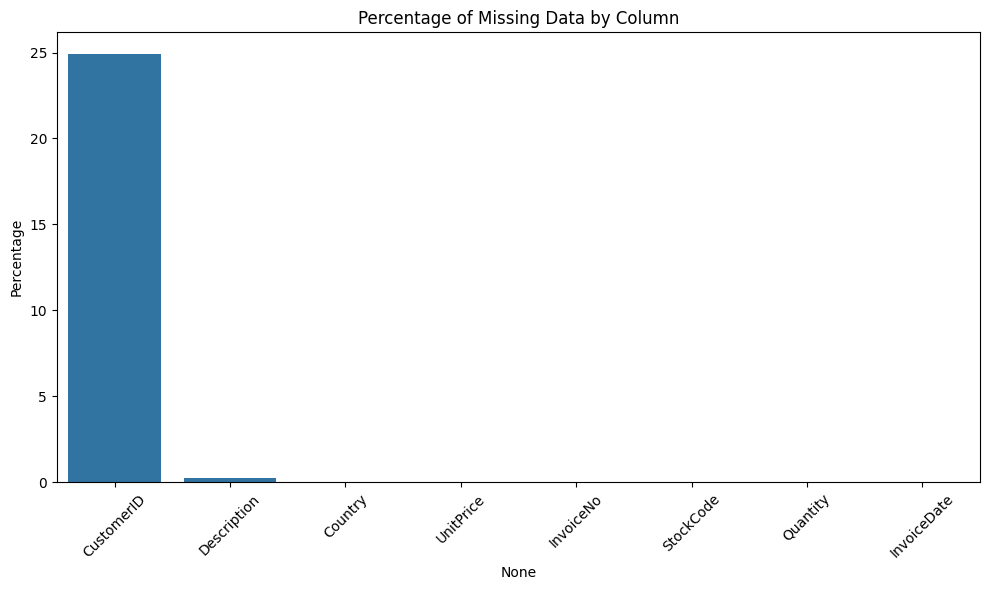

In [7]:
# Visualize missing data percentage
plt.figure(figsize=(10, 6))
sns.barplot(x=persentase_missing.index, y=persentase_missing.values)
plt.title('Percentage of Missing Data by Column')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Analyze missing data by country
missing_data_countries = data[data.isnull().any(axis=1)]['Country'].value_counts()
print("Negara yang memiliki missing value : ")
print(missing_data_countries)

Negara yang memiliki missing value : 
Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Australia              5
Singapore              3
Canada                 3
Bahrain                2
Name: count, dtype: int64


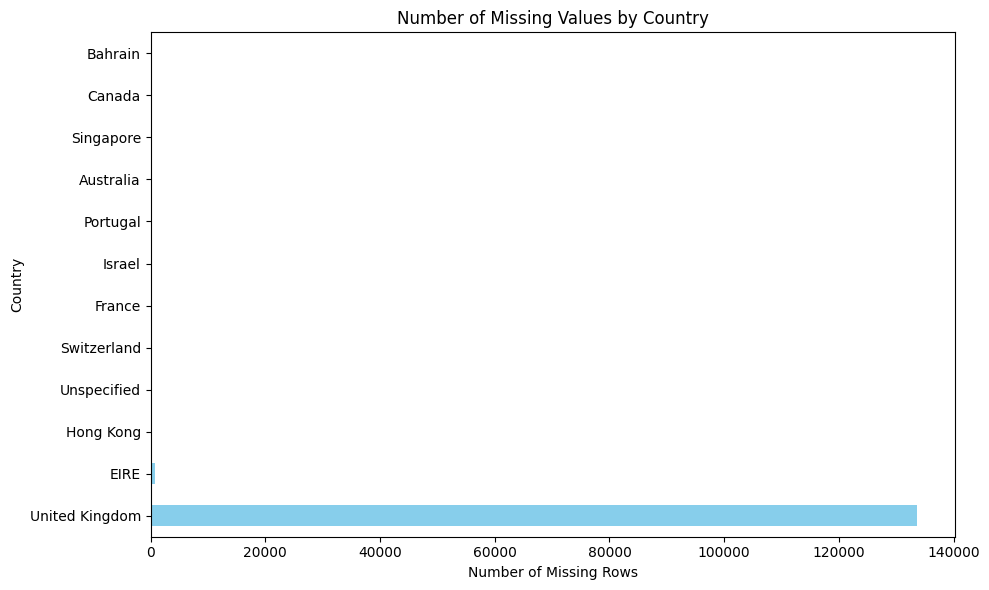

In [9]:
# Visualize missing data by country
plt.figure(figsize=(10, 6))
missing_data_countries.plot(kind='barh', color='skyblue')
plt.title('Number of Missing Values by Country')
plt.xlabel('Number of Missing Rows')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [10]:
# Task 2a: Data Cleaning
for col in data.columns:
    if col == 'CustomerID':
        # Skip CustomerID for separate handling later
        continue

    if data[col].isnull().sum() > 0:
        if data[col].dtype in ['int64', 'float64']:
            # Fill numerical columns with median
            median_value = data[col].median()
            data[col] = data[col].fillna(median_value)
            print(f"Kolom '{col}' (Numerik) diisi dengan median: {median_value:.2f}")
        elif data[col].dtype == 'object':
            # Fill categorical columns with mode
            mode_value = data[col].mode()[0]
            data[col] = data[col].fillna(mode_value)
            print(f"Kolom '{col}' (Kategorikal) diisi dengan mode: '{mode_value}'")

# Handle missing values in CustomerID
# Fill missing CustomerID with mode for each country
data["CustomerID"] = data.groupby("Country")["CustomerID"].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0)  # Use 0 if no mode available
)

# Verify that no missing data remains
print(data.isnull().sum())

# Save cleaned data to Excel
data.to_excel("Online-Retail-Clean.xlsx", index=False)

Kolom 'Description' (Kategorikal) diisi dengan mode: 'WHITE HANGING HEART T-LIGHT HOLDER'
Kolom 'UnitPrice' (Numerik) diisi dengan median: 2.08
Kolom 'Country' (Kategorikal) diisi dengan mode: 'United Kingdom'
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


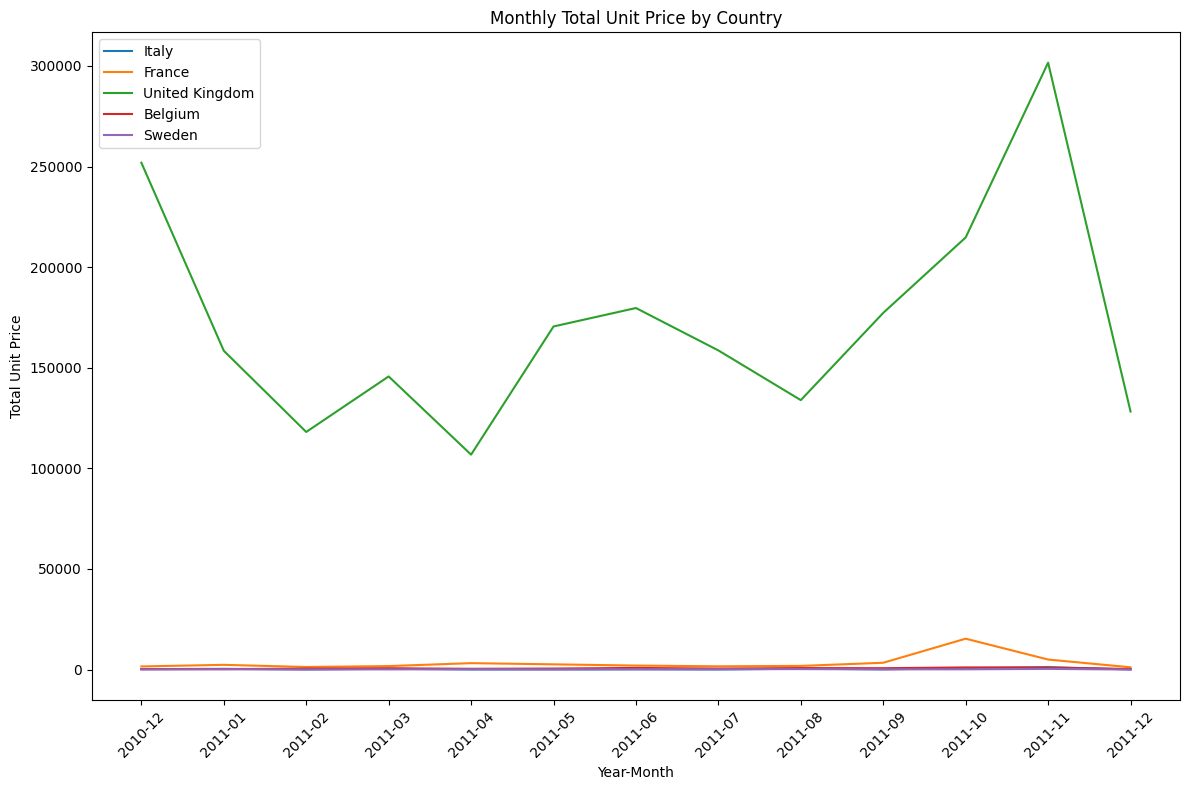

In [11]:
# Task 4: Aggregation by Country and Month
# Add a YearMonth column for monthly aggregation
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Aggregate total UnitPrice by country and month
aggregation = data.groupby(['Country', 'YearMonth'])['UnitPrice'].sum().reset_index()
aggregation.rename(columns={'UnitPrice': 'TotalUnitPrice'}, inplace=True)

# Save aggregation result
aggregation.to_excel("Aggregasi.xlsx", index=False)

# Visualize Monthly Aggregation for Top 5 Countries
top_countries = aggregation['Country'].value_counts().head(5).index
plt.figure(figsize=(12, 8))
for country in top_countries:
    country_data = aggregation[aggregation['Country'] == country]
    plt.plot(country_data['YearMonth'].astype(str), country_data['TotalUnitPrice'], label=country)

plt.title('Monthly Total Unit Price by Country')
plt.xlabel('Year-Month')
plt.ylabel('Total Unit Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Task 5: Sampling by Alpha
def stratified_sampling(df, alpha):
    """
    Perform stratified sampling for each country.
    Alpha determines the proportion of samples from each country.
    """
    # Calculate the sample sizes for each country
    sample_sizes = (df['Country'].value_counts() * alpha).round().astype(int)

    # Perform sampling for each country
    samples = df.groupby("Country").apply(
        lambda x: x.sample(n=min(len(x), sample_sizes.get(x.name, 0)), random_state=42)
    ).reset_index(drop=True)

    return samples, sample_sizes

# Alpha = 0.03
samples_alpha_003, sizes_alpha_003 = stratified_sampling(data, alpha=0.03)
samples_alpha_003.to_excel("Sampling_alpha_003.xlsx", index=False)

# Alpha = 0.01
samples_alpha_001, sizes_alpha_001 = stratified_sampling(data, alpha=0.01)
samples_alpha_001.to_excel("Sampling_alpha_001.xlsx", index=False)

<ipython-input-12-c2f704cab500>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = df.groupby("Country").apply(
<ipython-input-12-c2f704cab500>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = df.groupby("Country").apply(


In [13]:

# Output generated files
print("Processing complete. Files generated:")
print("1. Cleaned Data: Online-Retail-Clean.xlsx")
print("2. Aggregated Data: Aggregasi.xlsx")
print("3. Sampling Alpha 0.03: Sampling_alpha_003.xlsx")
print("4. Sampling Alpha 0.01: Sampling_alpha_001.xlsx")

Processing complete. Files generated:
1. Cleaned Data: Online-Retail-Clean.xlsx
2. Aggregated Data: Aggregasi.xlsx
3. Sampling Alpha 0.03: Sampling_alpha_003.xlsx
4. Sampling Alpha 0.01: Sampling_alpha_001.xlsx
